In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from shutil import copyfile, move

import glob
import time
import os

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from datetime import datetime
from tensorflow.keras.utils import to_categorical

from numba import cuda

In [2]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

In [3]:
import numpy as np

In [4]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

In [62]:
batch_size = 32
img_height = 80
img_width = 1024
SHUFFLE_BUFFER_SIZE = 100
data_dir = './spectrogramImgs5Classes/'
# data_dir = pathlib.Path(data_dir)

num_classes = 5
epochs = 100
patience = 50
sampling_rate = 100
NOW = datetime.now().strftime("%Y%m%d-%H%M%S")
seq_frame_len = 40
learning_rate = 0.001
# data_dir = pathlib.Path(data_dir)

def getImgNp(uri):
    img = np.array(PIL.Image.open(str(uri)));
#     print(img.shape)
    img = img.flatten()
#     print(img.shape)
    return img #.reshape(1,1024)
def spectrogramImage(directory):
    uris = sorted(glob.glob( directory + '*.png'))
    imgs = []
    for i, uri in enumerate(uris):
        img = getImgNp(uri)
#         print(img.shape)
#         plt.imshow(img)
        imgs.append(img)
#     img /= len(uris)
    imgs = np.array(imgs)
#     print(imgs.shape)
    return imgs

def averageImageAndSave(dirsArray, dest):
    for directory in dirsArray:
        img = spectrogramImage(directory) 
def averageImage(directory):
#     for directory in dirsArray:
    img = spectrogramImage(directory)
#         break;
    return img
#     plt.imsave('./dataset/spectrogramImgs/' + dest + '/' + str(time.time()) + '.png', img)

model_id = '{}_c{}b{}e{}p{}l{}s{}_{}'.format('sq', num_classes, batch_size, epochs, patience, seq_frame_len, sampling_rate, NOW)


In [80]:
x = []
y = []
train = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
#   seed=345,
  seed=645,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
#   seed=345,
  seed=645,
  image_size=(img_height, img_width),
  batch_size=batch_size)
for dataset in [train, test]:
    for element in dataset.as_numpy_iterator():
#     print(element[0].shape)
        for img in element[0]:
            x.append(img)
        for label in element[1]:
            y.append(label)

Found 4305 files belonging to 5 classes.
Using 3014 files for training.
Found 4305 files belonging to 5 classes.
Using 1291 files for validation.


In [81]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123, stratify=y)
# Don't use the testing partition for validation. Instead, create a smaller partition.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.28, random_state=123, stratify=y_train)


In [82]:
X_train = np.array(X_train)
y_train = to_categorical(np.array(y_train)).astype(np.int32)

X_test = np.array(X_test)
y_test = to_categorical(np.array(y_test)).astype(np.int32)

X_valid = np.array(X_valid)
y_valid = to_categorical(np.array(y_valid)).astype(np.int32)

In [83]:
print(X_valid.shape)
print(X_train.shape)
print(X_test.shape)

(844, 80, 1024, 3)
(2169, 80, 1024, 3)
(1292, 80, 1024, 3)


In [41]:
visualizer = tf.keras.callbacks.TensorBoard(log_dir='./spectro5Classes/tfevents_{}'.format(model_id))
earlystops = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True, verbose=0)

In [31]:
# # constructing tf dataset
# train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# val = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

# train = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
# val = val.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
# test = test.batch(batch_size)

In [75]:
num_classes = 5
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
#   layers.Dropout(0.5),
  layers.Conv2D(64, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
#   layers.Dropout(0.5),
  layers.Conv2D(128, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
#   layers.Dropout(0.5),
    
  layers.Conv2D(256, 3, activation='LeakyReLU'),
  layers.MaxPooling2D(),
#   layers.Dropout(0.5),
    
  layers.Flatten(),
#   layers.Dense(2048, activation='LeakyReLU'), # second model
#   layers.Dense(512, activation='LeakyReLU'),
  layers.Dense(num_classes, activation='softmax')
])

In [76]:
# # model.build(input_shape=(32, 80, 1024, 3))
model.build(input_shape=(32, 80, 1024, 3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (32, 80, 1024, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (32, 78, 1022, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (32, 39, 511, 32)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (32, 37, 509, 64)         18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (32, 18, 254, 64)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (32, 16, 252, 128)        73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (32, 8, 126, 128)        

In [96]:

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[visualizer, earlystops],
)


68/68 [==============================] - 1s 19ms/step - loss: 0.2103 - acc: 0.9355
train loss: 0.21027058362960815,
train acc: 0.9354541301727295
27/27 [==============================] - 0s 16ms/step - loss: 0.2289 - acc: 0.9230
val loss: 0.22891904413700104,
val acc: 0.9229857921600342
41/41 [==============================] - 1s 17ms/step - loss: 0.2072 - acc: 0.9358
test loss: 0.20723514258861542,
test acc: 0.9357585310935974
Test accuracy: 93.57585, AUC 95.98392, Precision 0.93578, Recall 0.93576, F1 0.93554, 

[[249   0   8   2   2]
 [  1 242   3   2  10]
 [ 17   2 227   7   6]
 [  3   0   4 250   0]
 [  1   9   4   2 241]]


/home/hicup/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<AxesSubplot:>

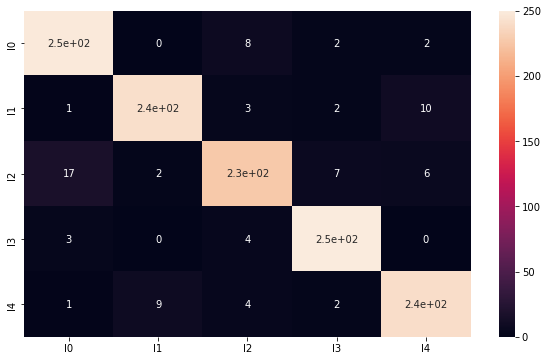

In [102]:

predict = model.predict(X_test)

y_test_true = to_categorical(y_test.argmax(1)).astype(np.int32)
y_test_pred = to_categorical(predict.argmax(1)).astype(np.int32)

auc = 100*roc_auc_score(y_test_true, y_test_pred, average='weighted', multi_class='ovo')
acc = 100*accuracy_score(y_test_true, y_test_pred,)

results = model.evaluate(X_train, y_train, batch_size=batch_size)
print("train loss: {},\ntrain acc: {}".format(results[0], results[1]))
results = model.evaluate(X_valid, y_valid, batch_size=batch_size)
print("val loss: {},\nval acc: {}".format(results[0], results[1]))
results = model.evaluate(X_test, y_test, batch_size=batch_size)
print("test loss: {},\ntest acc: {}".format(results[0], results[1]))
prec, rec, f1, _ = precision_recall_fscore_support(y_test_true, y_test_pred, average='weighted')
print('Test accuracy: {:.5f}, AUC {:.5f}, Precision {:.5f}, Recall {:.5f}, F1 {:.5f}, \n'.format( acc, auc, prec, rec, f1))
# print('Train accuracy: {:.2f}%'.format(100*accuracy))
cm = confusion_matrix(y_test.argmax(axis=1), predict.argmax(axis=1), [0, 1, 2, 3, 4])
print(cm)

index = ['l0', 'l1', 'l2', 'l3', 'l4']  
columns = ['l0', 'l1', 'l2', 'l3', 'l4']  
cm_df = pd.DataFrame(cm,columns,index)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)

In [100]:
# model.save('spectrogram_5G_93.h5')

In [88]:
# model.save('spectrogram_5G_85.h5')

In [101]:
model = tf.keras.models.load_model('spectrogram_5G_93.h5')
# mm = tf.keras.models.load_model('/home/hicup/Documents/SoliFiles/mySoliMOdels/dataset/RD_16_0_for_all_classes/RD_16/new_model_spectro_acc_73_sq_c11b32e100p30l40s100_20210617-214206.h5')


In [92]:

# predict = model.predict(X_test)

# y_test_true = to_categorical(y_test.argmax(1)).astype(np.int32)
# y_test_pred = to_categorical(predict.argmax(1)).astype(np.int32)

# auc = 100*roc_auc_score(y_test_true, y_test_pred, average='weighted', multi_class='ovo')
# acc = 100*accuracy_score(y_test_true, y_test_pred,)

# results = model.evaluate(X_train, y_train, batch_size=batch_size)
# print("train loss: {},\ntrain acc: {}".format(results[0], results[1]))
# results = model.evaluate(X_valid, y_valid, batch_size=batch_size)
# print("val loss: {},\nval acc: {}".format(results[0], results[1]))
# results = model.evaluate(X_test, y_test, batch_size=batch_size)
# print("test loss: {},\ntest acc: {}".format(results[0], results[1]))
# prec, rec, f1, _ = precision_recall_fscore_support(y_test_true, y_test_pred, average='weighted')
# print('Test accuracy: {:.5f}, AUC {:.5f}, Precision {:.5f}, Recall {:.5f}, F1 {:.5f}, \n'.format( acc, auc, prec, rec, f1))
# # print('Train accuracy: {:.2f}%'.format(100*accuracy))
# cm = confusion_matrix(y_test.argmax(axis=1), predict.argmax(axis=1), [0, 1, 2, 3, 4])
# print(cm)

# index = ['l0', 'l1', 'l2', 'l3', 'l4']  
# columns = ['l0', 'l1', 'l2', 'l3', 'l4']  
# cm_df = pd.DataFrame(cm,columns,index)                      
# plt.figure(figsize=(10,6))  
# sns.heatmap(cm_df, annot=True)

In [93]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 80, 1024, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 78, 1022, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 39, 511, 32)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 509, 64)       18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 254, 64)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 252, 128)      73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 8, 126, 128)      